# Using the Poisson-Boltzmann solver code with real data. 

This example uses real data generated for the 111 grain boundary orientation in gadolinium doped ceria ( $\mathrm{Gd-CeO_2}$ ). The data was generated using METADISE which is a computer program that performs atomic scale simulations of crystal structures. These simulations allow dislocations, surfaces and interfaces to be studied. METADISE has been used to study a number of grain boundaries in gadolinium doped ceria and individual defect energies and positions were calculated for gadolinium ions at cerium sites and vacancies at oxygen sites. 

In [2]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/project')

from project.defect_species import Defect_Species
from project.set_of_sites import Set_of_Sites
from project.constants import boltzmann_eV
from project.onedefect_onedopant_calculations import *
from project.general_calculations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

In [3]:
alpha = 0.0005
conv = 1e-8
grid_x_min = -6.0e-9
grid_x_max = +6.0e-9
bulk_region_x_min = 1.4e-8 
bulk_region_x_max = 1.8e-8

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp = [ 573.15, 673.15, 773.15, 873.15, 973.15, 1073.15, 1173.15, 1273.15, 1373.15, 1473.15, 1573.15, 1673.15, 1773.15, 1873.15 ]

In [4]:
data_3 = '/Users/glw33/Documents/papers/Gd-CeO2_SC/supporting_information/examples/data_for_examples/111_new_data_string.txt'

In [5]:
valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.01, 0.04 ], [ 0.0125, 0.05 ], [ 0.025, 0.1 ], [ 0.0375, 0.15 ], [ 0.05, 0.2 ], [ 0.0625, 0.25 ], [ 0.075, 0.3 ], [ 0.0875, 0.35 ] ])

### Output defect mole fractions.

When the calculation is run on this real system, the bulk mole fraction of each defect species in the output is less than the desired bulk mole fraction for each defect, therefore a correction is required to ensure that that bulk mole fraction of each defect in the output is what it should be. 
To achieve this, an array of 8 different mole fractions between [0.01, 0.04] and [0.0875, 0.35] (as defined above) are used as the input for the calculation at each temperature and a `bulk_region_x_min` and a `bulk_region_x_max` selected so there is no grain boundary effects. Once the calculation has been completed for each of the mole fractions at a given temperture, a linear regression is performed on the input mole fraction against the output mole fraction. Once the slope and intercept has been obtained the mole fraction required as input to give the desired mole fraction as output can be calculated. This is done for each temperature and the results stored in an array called mole fractions (overwriting the original array).

In [6]:
# Empty lists are created to store the slope and intercept from the linear regression.
slope_list = []
intercept_list = []

# fixed refers to whether the immobile defect is to be fixed to its bulk mole fraction.
fixed = True

# Loops over temperature.
for t in temp:
    # Creates an empty list to store the uncorrected output mole fractions.
    avg_Vo_molfracs = []
    # Loops over input mole fractions. 
    for m in mole_fractions:
        # From the system specific constants a defect species is produced by zipping together the defect label, valence and mole fraction for each species.
        defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
        data_file = open( data_3, 'r')
        # Each line in the input data file is read and split into individual strings.
        # These individual strings are then created into sites providing the second element on each line ( the x coordinate)
        # is within the range defined. These sites are then compiled into a list 'all_sites'
        input_data = [ line.split() for line in data_file.readlines() ]
        input_data = [ line for line in input_data if ( float(line[1]) > bulk_region_x_min and float(line[1]) < bulk_region_x_max ) ] 
        all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
        # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
        for site in all_sites.subset( 'Ce' ):
            site.defect_with_label('Gd').fixed = True
        # Runs the Poisson-Boltzmann solver and returns the output mole fraction. 
        avg_Vo_MF = calculate_average_molefraction( t, bulk_region_x_min, bulk_region_x_max, b, c, index, alpha, conv, all_sites, site_labels, 'dirichlet')
        avg_Vo_molfracs.append( avg_Vo_MF ) 
    # the linear regression is performed on the input and output mole fractions. 
    slope, intercept, rvalue, pvalue, stderr = stats.linregress( mole_fractions[:,0], avg_Vo_molfracs )
    slope_list.append( slope )
    intercept_list.append( intercept )

# The percentage gadolinium content is defined here and is converted into a desired mole fraction for the 'real' calculation.
percentage_Gd = 20
desired_mobile_defect_MF = ( percentage_Gd / 100 ) / 4
# The input mole fractions that will give the desired output mole fractions for the given percentage gadolinium content are calculated from the linear regreassion results.
# This is done for each temperature and is compiled into an array overwriting the original mole_fractions array.
mole_fractions = np.array( [ MF( desired_mobile_defect_MF, s, i ) for s, i in zip( slope_list, intercept_list ) ] )

### Running the Poisson-Boltzmann solver and calculating the grain boundary properties.

Once the input mole fractions have been calculated, the Poisson-Boltzmann solver is run.

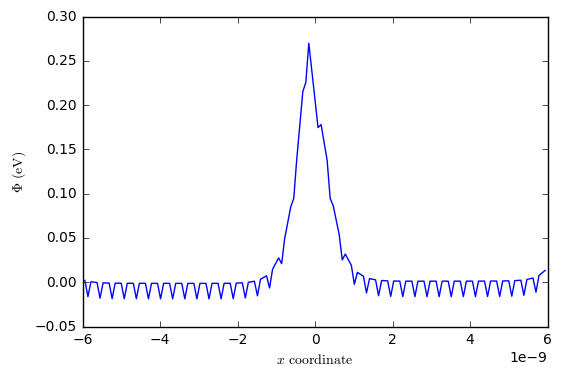

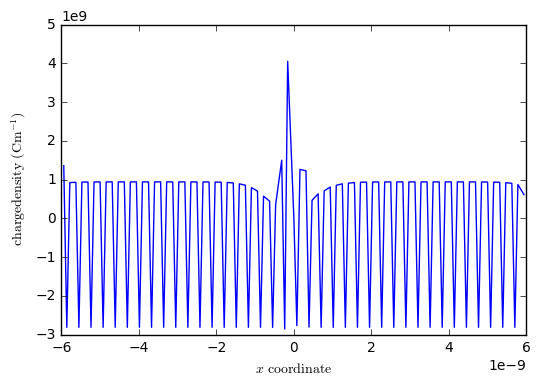

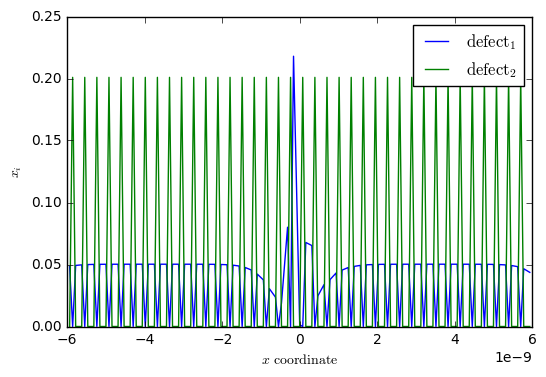

In [7]:
# Empty lists are created to store the calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature.
ratios = []
bulk_density_list = []
max_phi_list = []

# Each temperature and its corresponding input mole fraction are zipped together. These are then looped over for each calculation.
for t, m in zip( temp, mole_fractions ):
    # From the system specific constants a defect species is produced by zipping together the defect label, valence and mole fraction for each species.
    defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
    data_file = open( data_3, 'r')
    # Each line in the input data file is read and split into individual strings.
    # These individual strings are then created into sites providing the second element on each line ( the x coordinate)
    # is within the range of values either side of the grain boundary defined. These sites are then compiled into a list 'all_sites'
    input_data = [ line.split() for line in data_file.readlines() ]
    input_data = [ line for line in input_data if ( float(line[1]) > grid_x_min and float(line[1]) < grid_x_max ) ] 
    all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
    # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
    for site in all_sites.subset( 'Ce' ):
        site.defect_with_label('Gd').fixed = True
    # The Poisson-Boltzmann solver is run and returns the site explicit properties.
    # These properties are stacked into a table and saved in a .dat file.
    grid, phi, rho, probabilities, resistivity_ratio, Vo_mole_fraction, Gd_mole_fraction, bulk_density, niter = calculate_GB_properties( t, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_MF, all_sites, site_labels, 'dirichlet'  )
    site_data = np.column_stack( ( grid.x, phi, rho, probabilities, Vo_mole_fraction, Gd_mole_fraction ) )
    site_data_filename = '{}_site_data_percentGd{}_temp{}_bulkfixed{}.dat'.format( index, percentage_Gd, t, fixed )
    header = ' x, phi, rho, probabilities, Vo_MF, Gd_MF, temp, Gd_fixed_to_bulk '
    np.savetxt( site_data_filename, site_data, header = header )
    # The calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature are stored in the defined lists.
    ratios.append( resistivity_ratio )   
    bulk_density_list.append( bulk_density )
    max_phi_list.append( max(phi) )
    

# Once the site explicit properties, and resistivity ratio have been calculated, the additional grain boundary properties can be calculated.

# The ionic conductivity activation energy
Ea = calculate_activation_energy( ratios, temp ) 

# The space charge potential calculated using the Mott-Schottky approximation.
MS_phi = np.array( [ float(solve_MS_for_phi(r, t, valence[0])) for r, t in zip( ratios, temp ) ] )

# The space charge width.
SCW = np.array( [ space_charge_width( b, t, valence[0], p ) for t, p, b in zip( temp, max_phi_list, bulk_density_list ) ] )

# And the space charge width calculated from the Mott-Schottky space charge potential.
MS_SCW = np.array( [ space_charge_width( b, t, valence[0], p ) for t, p, b in zip( temp, MS_phi, bulk_density_list ) ] )

# Plotting the potential, charge denisty and defect mole fractions for the last calculation.
plt.plot(grid.x, phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, Vo_mole_fraction, label = '$\mathrm{defect_1}$')
plt.plot(grid.x, Gd_mole_fraction, label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

In [8]:
# The grain boundary properties are put together in a pandas DataFrame and stored as a .csv file.

filename = 'GB_propertiespercentGd{}.csv'.format( percentage_Gd )
data = pd.DataFrame( np.column_stack( ( temp[1:-1], max_phi_list[1:-1], ratios[1:-1], Ea, MS_phi[1:-1], SCW[1:-1], MS_SCW[1:-1] ) ),
       columns = [ 'temp', 'phi_0', 'r_gb', 'delta_E_act', 'phi_0_MS', 'space_charge_width', 'MS_space_charge_width'] )
data['GB'] = index
data['Gd%'] = percentage_Gd
print(data)
data.to_csv( filename )

       temp     phi_0         r_gb  delta_E_act  phi_0_MS  space_charge_width  \
0    673.15  0.342074  1762.658964     0.749880  0.305152            3.446518   
1    773.15  0.334578   332.040836     0.745252  0.288377            3.408544   
2    873.15  0.327408    92.637893     0.735545  0.270694            3.371827   
3    973.15  0.320543    34.186574     0.716877  0.252421            3.336287   
4   1073.15  0.313961    15.596475     0.685496  0.234056            3.301857   
5   1173.15  0.307646     8.423838     0.639733  0.216221            3.268480   
6   1273.15  0.301582     5.221131     0.581381  0.199512            3.236106   
7   1373.15  0.295754     3.619187     0.515374  0.184352            3.204689   
8   1473.15  0.290152     2.742290     0.447871  0.170892            3.174193   
9   1573.15  0.284764     2.225910     0.384128  0.159019            3.144583   
10  1673.15  0.279580     1.902999     0.327371  0.148406            3.115828   
11  1773.15  0.274591     1.